# EDA

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wordcloud
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

all_sw = stopwords.words('spanish')


In [4]:
df = pd.read_csv("Datathon 2024 - Reto Hey - Dataset Público - Sheet1.csv")
df['tweet'].iloc[7]

'Muchas gracias 😊'

## Wordcloud

### Removing Emojis

In [5]:
# Removing emojis as first attempt to create wordloud

def remove_emojis(text):
    return emoji.replace_emoji(text, '')

def emoji_to_text(text):
    return emoji.demojize(text)

def remove_stopwords(text):
    words = word_tokenize(text, language='spanish')
    return ' '.join([word.lower() for word in words if word.lower() not in all_sw])

def clean_text(df, emoji='remove', strip=True, sw=True):
    df1 = df.copy()
    if emoji == 'remove':
        df1['clean_tweet'] = df1['tweet'].apply(remove_emojis)
    elif emoji == 'text':
        df1['clean_tweet'] = df1['tweet'].apply(emoji_to_text)
    
    if strip:
        df1['clean_tweet'] = df1['clean_tweet'].str.rstrip()
        df1['clean_tweet'] = df1['clean_tweet'].str.replace(r'\s+', ' ', regex=True).str.strip()

    if sw:
        df1['clean_tweet'] = df1['clean_tweet'].apply(remove_stopwords)
    return df1

In [6]:
df1 = clean_text(df)
df1['clean_tweet'].iloc[7]

'muchas gracias'

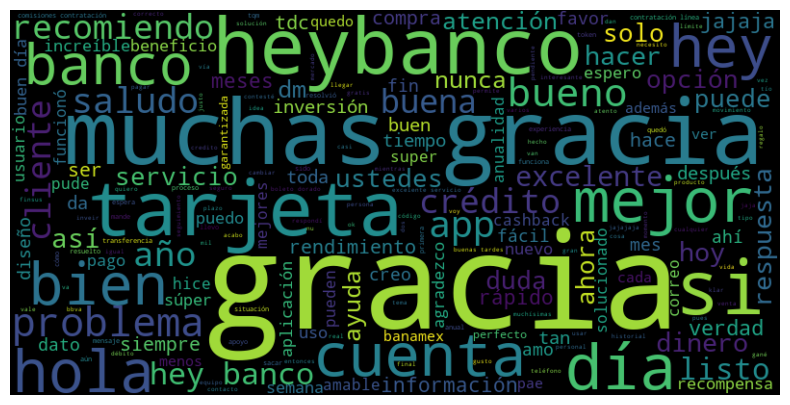

In [7]:
# Join all text in one string
text = ' '.join(df1['clean_tweet'].tolist())

# Wordcloud
wc = wordcloud.WordCloud(width=800, height=400).generate(text)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### New stopwords

In [16]:
new_sw = ['heybanco', 'muchas', 'mucha', 'gracia', 'gracias', 'hola', 'día', 'días', 'si', 'tarjeta', 'listo', 'hey', 'banco', 'tan', 'hace', 'solo', 'favor', 'ahora', 'así']
all_sw = list(all_sw) + new_sw

df2 = clean_text(df1, emoji='remove', strip=False)

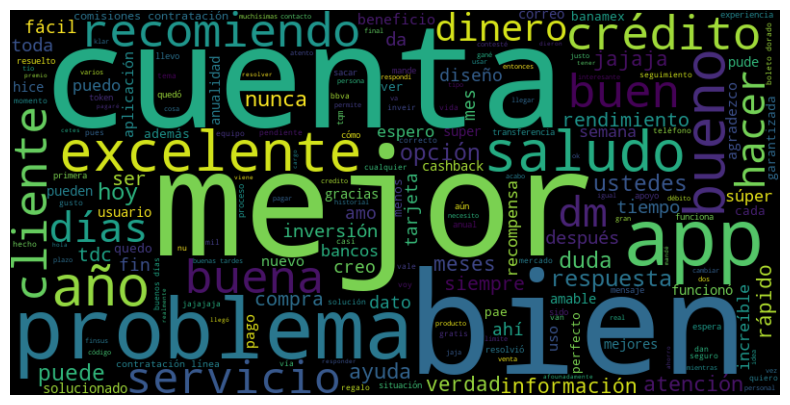

In [9]:
# Join all text in one string
text = ' '.join(df2['clean_tweet'].tolist())

# Wordcloud
wc = wordcloud.WordCloud(width=800, height=400).generate(text)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### With Emojis

In [43]:
df3 = clean_text(df1, emoji='text')
df3['clean_tweet'].iloc[7]

': smiling_face_with_smiling_eyes :'

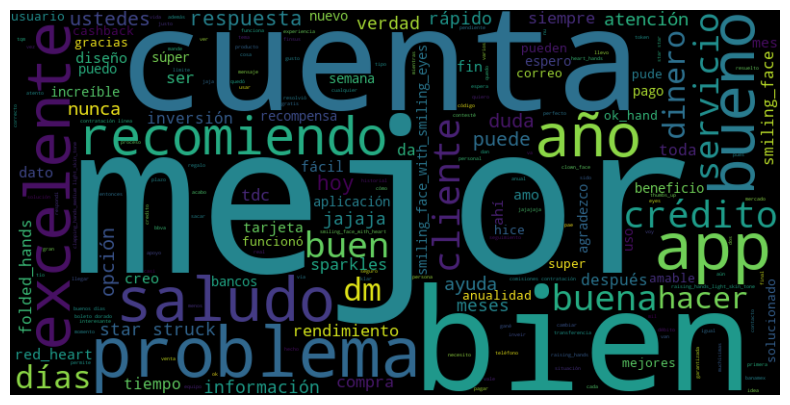

In [11]:
# Join all text in one string
text = ' '.join(df3['clean_tweet'].tolist())

# Wordcloud
wc = wordcloud.WordCloud(width=800, height=400).generate(text)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# Machine learning

In [34]:
# TFIDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=all_sw, ngram_range=(1,2))
X = tfidf_vectorizer.fit_transform(df3['clean_tweet'])

# Clustering
number_of_clusters = 3
kmeans = KMeans(n_clusters=number_of_clusters, init='k-means++', max_iter=100, n_init=1, random_state=0)
kmeans.fit(X)

order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()

for i in range(number_of_clusters):
    print('Cluster %d: ' %i),
for ind in order_centroids[i, :10]:
    print(' %s' % terms[ind])

Cluster 0: 
Cluster 1: 
Cluster 2: 
 excelente
 excelente servicio
 servicio
 bien excelente
 excelente opción
 excelente información
 opción
 atención
 servicio atención
 atención clientes


WordCloud for cluster 1


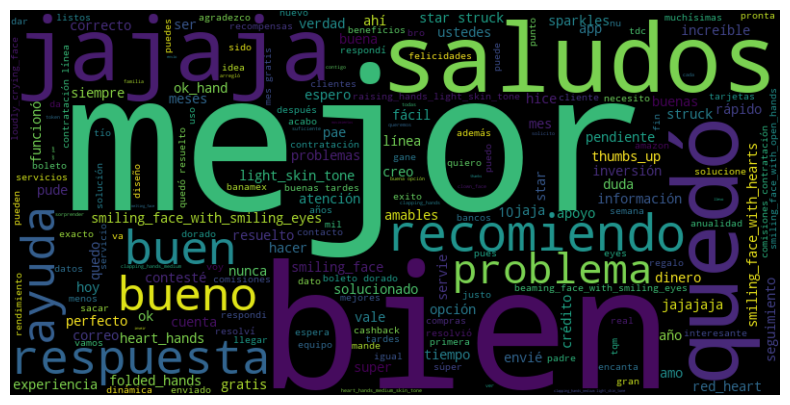

WordCloud for cluster 2


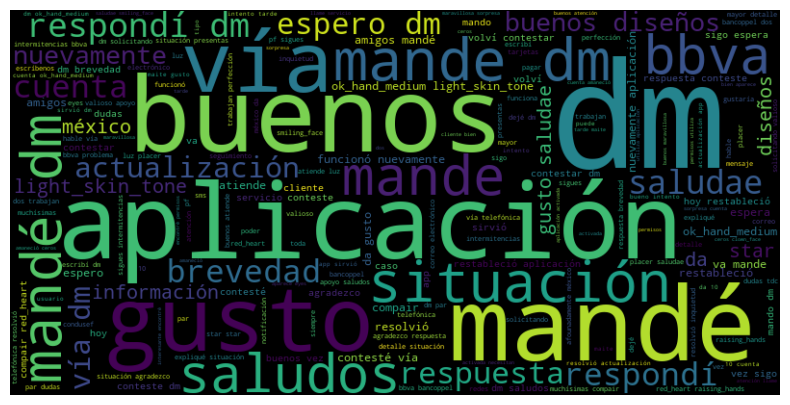

WordCloud for cluster 3


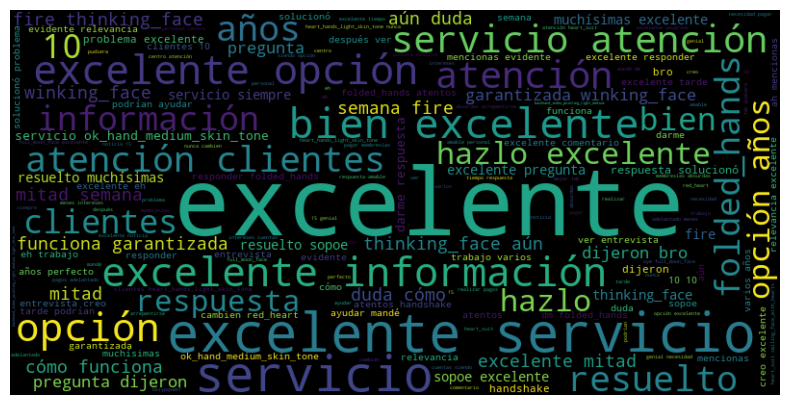

In [36]:
# Crear una función para generar WordClouds para cada cluster
def generate_wordclouds(kmeans_model, terms):
    # Número de clusters
    n_clusters = kmeans_model.n_clusters
    order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1]
    
    for i in range(n_clusters):
        print(f"WordCloud for cluster {i+1}")
        terms_freq = {}
        for ind in order_centroids[i, :]:  # Tomamos los top 10 términos de cada cluster
            terms_freq[terms[ind]] = kmeans_model.cluster_centers_[i, ind]
        
        # Crear el WordCloud
        wc = wordcloud.WordCloud(width=800, height=400).generate_from_frequencies(terms_freq)
        
        # Visualización
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.show()

generate_wordclouds(kmeans, terms)

In [48]:
from gensim import corpora, models
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer

# Preprocessing the data
tokenizer = RegexpTokenizer(r'\w+')
stemmer = SnowballStemmer('spanish')

def preprocess(text):
    df1 = df.copy()
    tokens = tokenizer.tokenize(text.lower())
    #stemmed_tokens = [stemmer.stem(i) for i in tokens]
    return tokens

df4 = df3.copy()
df4['processed'] = df4['clean_tweet'].apply(preprocess)

# Creating a dictionary from the data
dictionary = corpora.Dictionary(df4['processed'])

# Creating a document-term matrix
corpus = [dictionary.doc2bow(text) for text in df4['processed']]

In [49]:
df4.head()

,date,time,tweet,clean_tweet,processed
0,2023-01-01,NaN,"Resuelto, muchísimas gracias , excelente servi...","resuelto , muchísimas , excelente servicio sie...","[resuelto, muchísimas, excelente, servicio, si..."
1,2023-01-02,NaN,"Muchas gracias, espero su dm",", espero dm","[espero, dm]"
2,2023-01-02,NaN,Muchas gracias!,!,[]
3,2023-01-02,NaN,Algo similar me paso. Quería renovar mi token ...,similar paso . quería renovar token poder hace...,"[similar, paso, quería, renovar, token, poder,..."
4,2023-01-02,NaN,Yeeeei! a través de mi cuenta en acabo de cont...,yeeeei ! través cuenta acabo contratar cuenta ...,"[yeeeei, través, cuenta, acabo, contratar, cue..."


In [50]:
# Building the LDA model
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Printing the topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.007*"buena" + 0.006*"buen" + 0.006*"ser" + 0.005*"cashback" + 0.005*"hacer"')
(1, '0.010*"excelente" + 0.009*"star" + 0.008*"servicio" + 0.006*"bien" + 0.006*"pae"')
(2, '0.010*"mejor" + 0.007*"comisiones" + 0.007*"dinero" + 0.006*"línea" + 0.006*"2"')
(3, '0.009*"problema" + 0.006*"crédito" + 0.005*"app" + 0.005*"verdad" + 0.005*"dm"')
(4, '0.009*"light_skin_tone" + 0.008*"saludos" + 0.008*"bueno" + 0.008*"cuenta" + 0.007*"bien"')
